In [14]:
from mongoengine import *
import numpy as np
import datetime 
import pandas
import matplotlib.pyplot as plt
import sklearn
import tabulate

In [15]:
connect("GDP-test", host = "localhost", port = 27017)
class Detection(Document):
    id_webcam = IntField(required=True)
    city = StringField(required=True)
    location = StringField(required=True)
    latitude = FloatField(required=True)
    longitude = FloatField(required=True)
    numPeople = IntField(required=True)
    date = DateTimeField(required=True)
    time = DateTimeField(required=True)
    type = IntField(required=True)
    weather_description = StringField()
    temperature = FloatField()
    day_of_week = IntField()

In [23]:
#print(Detection.objects.distinct('city')) # vedere se posso prendere solo le città per poi fare query distinte
table = pandas.DataFrame(Detection.objects(city='Roma').as_pymongo()) #prelevo i dati di roma

most_freq = lambda x: x.value_counts(dropna=False).index[0]

table_a = table
table_a = table_a.drop(columns = ['_id','id_webcam','city','type','date','location','latitude','longitude'])
table_a['time'] = pandas.to_datetime(table_a['time'])
table_a.sort_values(by='time', inplace=True)
#print(table_a.columns)
#table_1 = table_a.resample('30T', on='time').agg({'numPeople': 'mean', 'temperature' : 'mean', 'weather_description'}).head(20)
tb = table_a.groupby([pandas.Grouper(key='time', freq='30T')], as_index=False).agg( time=('time', most_freq)
                                                                   , meanPeople=('numPeople', 'mean')
                                                                   , temp=('temperature','mean')
                                                                   , weather=('weather_description', most_freq )
                                                                   , day_of_week=('day_of_week', most_freq))


tb = tb.dropna()



# tb.plot('time','meanPeople')
#tb['hour'] = tb['time'].apply(tb['time'].hour)
# #print(type tb['time'])
#print(tb.to_markdown())
#print(table_a.to_markdown())
# tb.plot('time','numPeople')

<AxesSubplot:xlabel='time'>

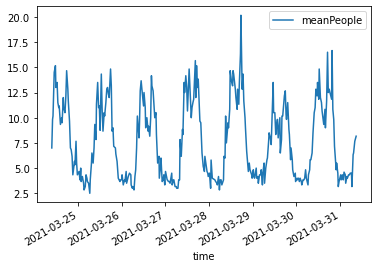

In [24]:
#print(tb.columns)
tb.plot('time','meanPeople')

In [ ]:
# s1 = datetime.datetime(2021,3,26)
# e1 = datetime.datetime(2021,3,27)
# q1 = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
# t1 = pandas.DataFrame(Detection.objects(__raw__=q1).as_pymongo())


# table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
# table.plot('time','numPeople')

In [5]:
tb['time'] = tb['time'].dt.hour
#tb['time'] = (tb['time'].dt.hour).astype(int)#modifico le colonne con i valori che mi servono

In [6]:
import sklearn.model_selection

tb['weather'] = pandas.get_dummies(tb['weather']) #il weather viene convertito con parametri interi

tb = tb.reset_index()
#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    tb[['time','temp','day_of_week','weather']], 
    tb['meanPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)

In [7]:
#Modello tipo Regressione Lineare standard
import sklearn.linear_model

modelLReg = sklearn.linear_model.LinearRegression()
#provo a dargli in pasto tutto
#prima di questo ora bisogna dividere tutto il dataset in 70-30
modelLReg.fit(x_train, y_train)


# The coefficients
print('Coefficients: \n', modelLReg.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((modelLReg.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % modelLReg.score(x_test, y_test))



Coefficients: 
 [-0.00319856  0.74026758  0.18338905  1.06585258]
Residual sum of squares: 6.24
Variance score: 0.53


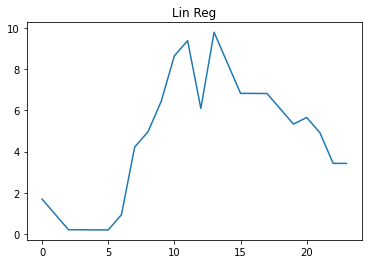

In [8]:
data = {'time':  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
        'temp':  [5,4,3,3,3,3,4,7,8,10,13,14,11,16,14,12,12,12,11,10,9,8,6,6],
        'day_of_week': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
        'weather':     [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1]
        }

df = pandas.DataFrame (data, columns = ['time','temp','day_of_week','weather'])

#print(model.predict(df))
plt.title("Lin Reg")
plt.plot(df['time'],modelLReg.predict(df))

Lasso score : 0.51


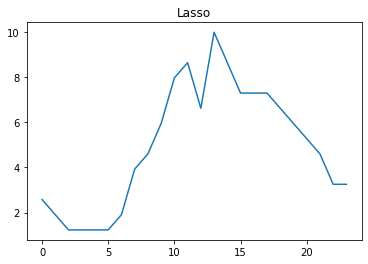

In [9]:
#Modello tipo Lasso
modelLasso = sklearn.linear_model.Lasso()

modelLasso.fit(x_train,y_train)
print('Lasso score : %.2f' % modelLasso.score(x_test,y_test))
plt.title("Lasso")
plt.plot(df['time'],modelLasso.predict(df))

Ridge score : 0.44


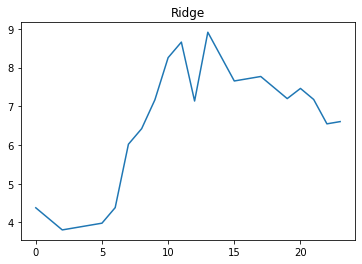

In [10]:
#Modello tipo Ridge
modelRidge = sklearn.linear_model.Ridge(normalize = True)

modelRidge.fit(x_train,y_train)
print('Ridge score : %.2f' % modelRidge.score(x_test,y_test))
plt.title("Ridge")
plt.plot(df['time'],modelRidge.predict(df))

Forest score : 0.85


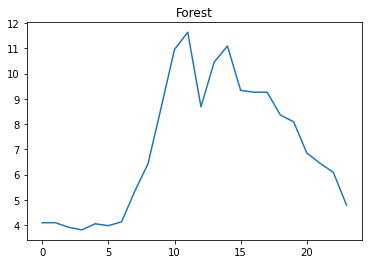

In [11]:
#Modello tipo Forest
from sklearn.ensemble import RandomForestRegressor

modelForest = RandomForestRegressor()

modelForest.fit(x_train,y_train)
print('Forest score : %.2f' % modelForest.score(x_test,y_test))
plt.title("Forest")
plt.plot(df['time'],modelForest.predict(df))

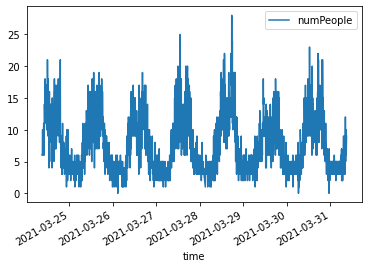

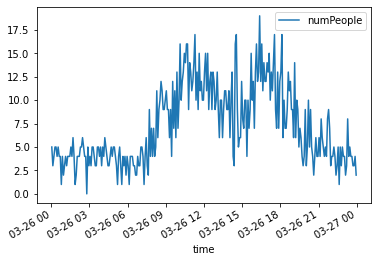

In [12]:
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude']) #tolgo colonne inutili
table.plot('time','numPeople')
table['time'] = table['time'].dt.strftime('%H').astype(int)#modifico le colonne con i valori che mi servono
table['weather_description'] = pandas.get_dummies(table['weather_description']) #il weather viene convertito con parametri interi
#print(table.to_markdown())

start = datetime.datetime(2021,3,26)
end = datetime.datetime(2021,3,27)
raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
table.plot('time','numPeople')

#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    table[['time','temperature','day_of_week','weather_description']], 
    table['numPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)


In [13]:
# model = sklearn.linear_model.LinearRegression()
# #provo a dargli in pasto tutto
# #prima di questo ora bisogna dividere tutto il dataset in 70-30
# model.fit(x_train, y_train)


# # The coefficients
# print('Coefficients: \n', model.coef_)

# # The mean square error
# print("Residual sum of squares: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))

# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % model.score(x_test, y_test))

# plt.plot(x_test['time'],y_test)


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [ ]:

#robe vecchie sbagliate non guardare

# time, temperature, weather, numP = table['time'].dt.strftime('%H').astype(int),table['temperature'],table['weather_description'],table['numPeople']
# time = np.asarray(time)
# temperature = np.asarray(temperature)
# weather = np.asarray(weather)
# numP = np.asarray(numP)
# weatherDict = {'clear sky':0}

In [ ]:
# for i in range(weather.size):
#     weather[i] = weatherDict[weather[i]]

In [ ]:
# temperature = temperature.reshape(-1,1)
# time = time.reshape(-1,1)
# weather = weather.reshape(-1,1)
# timeTemp = np.concatenate((time,temperature,weather),axis = 1)
# print(timeTemp)
# model = sklearn.linear_model.LinearRegression()
# model.fit(timeTemp,numP) 

In [ ]:
# start = datetime.datetime(2021,3,24)
# end = datetime.datetime(2021,3,29)
# raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
# table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
# table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])